In [1]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.7.0+cpu'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import zipfile
from pathlib import Path
# Define paths
# Replace 'your-folder' with the actual path inside your Google Drive
zip_path = Path("C:\\Users\\AQMJ\\Downloads\\glasses_nonglasses_classification.zip")
image_path = Path("C:\\Users\\AQMJ\\Downloads\\glasses_nonglasses_classification")
train_dir = os.path.join(image_path, 'train')
test_dir = os.path.join(image_path, 'test')


# Create directory if it doesn't exist
image_path.mkdir(parents=True, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(image_path)
print(f"Image path being used: {image_path}")

Unzipping data...
Image path being used: C:\Users\AQMJ\Downloads\glasses_nonglasses_classification


In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """

# Inspect directory structure and contents
  for dirpath, dirnames, filenames in os.walk(image_path):    
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 3 directories and 0 images in 'C:\Users\AQMJ\Downloads\glasses_nonglasses_classification'.
There are 2 directories and 0 images in 'C:\Users\AQMJ\Downloads\glasses_nonglasses_classification\glasses_nonglasses_classification'.
There are 2 directories and 0 images in 'C:\Users\AQMJ\Downloads\glasses_nonglasses_classification\glasses_nonglasses_classification\test'.
There are 0 directories and 10 images in 'C:\Users\AQMJ\Downloads\glasses_nonglasses_classification\glasses_nonglasses_classification\test\glasses'.
There are 0 directories and 10 images in 'C:\Users\AQMJ\Downloads\glasses_nonglasses_classification\glasses_nonglasses_classification\test\non_glasses'.
There are 2 directories and 0 images in 'C:\Users\AQMJ\Downloads\glasses_nonglasses_classification\glasses_nonglasses_classification\train'.
There are 0 directories and 25 images in 'C:\Users\AQMJ\Downloads\glasses_nonglasses_classification\glasses_nonglasses_classification\train\glasses'.
There are 0 directories and 25 

Found 280 images.


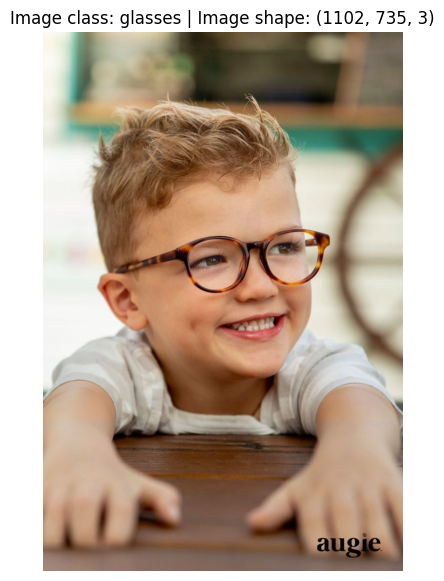

In [5]:
import random
# Collect image paths for .jpg and .jpeg files (case-insensitive)
image_path_list = []
image_path_list.extend(list(image_path.rglob("*.jpg")))
image_path_list.extend(list(image_path.rglob("*.jpeg")))
image_path_list.extend(list(image_path.rglob("*.JPG")))
image_path_list.extend(list(image_path.rglob("*.JPEG")))

# Check if any images were found
if not image_path_list:
    print(" Warning: No images found matching the patterns.")
    print("Please double-check your file extensions and directory structure.")
else:
    print(f"Found {len(image_path_list)} images.")

    # Choose a random image
    random_image_path = random.choice(image_path_list)

    # Get image class from parent directory
    image_class = random_image_path.parent.stem

    # Open image
    img = Image.open(random_image_path)

    # Convert to NumPy array
    img_as_array = np.asarray(img)

    # Plot the image
    plt.figure(figsize=(10, 7))
    plt.imshow(img_as_array)
    plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
    plt.axis(False)
    plt.show()


In [6]:
import os
from pathlib import Path
import torch
import shutil

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [7]:
#######################################################
#      Create dictionary for class indexes
#######################################################

# Get the list of class names from the training directory
classes = sorted(os.listdir(train_dir))

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx

{'glasses': 0, 'non_glasses': 1}

In [8]:
from torch.utils.data import Dataset

#######################################################
#               Define Dataset Class
#######################################################

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = list(Path(image_paths).glob("*/*.JPEG"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath).convert("RGB")  # ensure 3-channel image
        label_str = image_filepath.parent.name
        label = torch.tensor(class_to_idx[label_str])  # convert to tensor

        if self.transform:
            image = self.transform(image)

        return image, label


In [9]:
# Define transformations
data_transform = transforms.Compose(
    [transforms.Resize((224,224)), # Note the difference here compared to before
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

In [10]:
#######################################################
#                  Create Dataset
#######################################################

train_data_custom = CustomDataset(image_paths = train_dir, transform = data_transform)
test_data_custom = CustomDataset(image_paths =test_dir,transform = data_transform)

len(train_data_custom), len(test_data_custom)

(50, 20)

In [11]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
# The original variables 'train_data' and 'test_data' were not defined in the code.
# Removing the comparison with these undefined variables.
print(f"Length of train_data_custom: {len(train_data_custom)}")
print(f"Length of test_data_custom: {len(test_data_custom)}")

Length of train_data_custom: 50
Length of test_data_custom: 20


In [12]:
#######################################################
#                  Create Dataloader
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=4,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(train_dataloader_custom.dataset)
test_data_size = len(test_dataloader_custom.dataset)

print(train_data_size)
print(test_data_size)

50
20


In [13]:
# Grab a batch from the custom DataLoader
batch = next(iter(train_dataloader_custom))

# Check the type of what's returned
print(f"Type of batch: {type(batch)}")

# If it's a tuple (image, label), unpack it
images, labels = batch

# Print shapes for clarity
print(f"Image batch shape: {images.shape} -> [batch_size, channels, height, width]")
print(f"Label batch shape: {labels.shape} -> [batch_size]")


Type of batch: <class 'list'>
Image batch shape: torch.Size([4, 3, 224, 224]) -> [batch_size, channels, height, width]
Label batch shape: torch.Size([4]) -> [batch_size]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


Image batch shape: torch.Size([4, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label batch shape: torch.Size([4]) -> [batch_size]


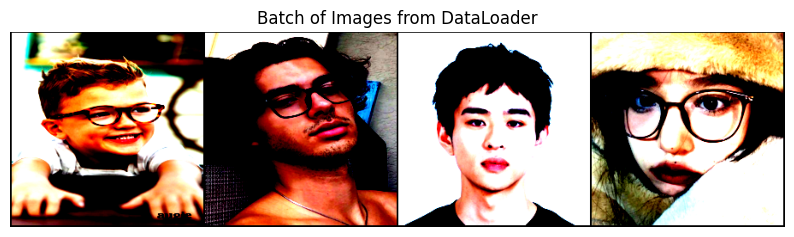

Labels in this batch: [0, 0, 1, 0]


In [14]:
import matplotlib.pyplot as plt
import torchvision

# Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_custom))

# Print shapes
print(f"Image batch shape: {img_batch.shape} -> [batch_size, color_channels, height, width]")
print(f"Label batch shape: {label_batch.shape} -> [batch_size]")

# Create a grid of images (useful for batch visualization)
img_grid = torchvision.utils.make_grid(img_batch, nrow=4)  # adjust nrow based on batch size

# Convert from tensor image (C, H, W) to numpy (H, W, C)
npimg = img_grid.permute(1, 2, 0).numpy()

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(npimg)
plt.title("Batch of Images from DataLoader")
plt.axis('off')
plt.show()

# Print label values for reference
print(f"Labels in this batch: {label_batch.tolist()}")


In [15]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 3)

# LOSS AND OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

c:\Users\AQMJ\OneDrive\Documents\solidworks\Uni stuff\deep learning\DeepLearning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AQMJ\OneDrive\Documents\solidworks\Uni stuff\deep learning\DeepLearning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
import torch
from torchvision import models
from torchsummary import summary

model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [17]:
import time
from tqdm.auto import tqdm

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device=torch.device('cpu')):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    # accuracy = torchmetrics.Accuracy(device=device)
    # Initialize the accuracy metric from torchmetrics
    # accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10).to(device)

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')

    return best_model, history

c:\Users\AQMJ\OneDrive\Documents\solidworks\Uni stuff\deep learning\DeepLearning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, loss_fn, optimizer, train_dataloader_custom, test_dataloader_custom, num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10


 10%|█         | 1/10 [00:09<01:25,  9.51s/it]

Epoch : 000, Training: Loss: 1.0110, Accuracy: 44.0000%, 
		Validation : Loss : 0.7495, Accuracy: 50.0000%, Time: 9.4116s
Epoch: 2/10


 20%|██        | 2/10 [00:18<01:12,  9.09s/it]

Epoch : 001, Training: Loss: 0.5362, Accuracy: 72.0000%, 
		Validation : Loss : 0.7001, Accuracy: 50.0000%, Time: 8.7983s
Epoch: 3/10


 30%|███       | 3/10 [00:26<01:02,  8.86s/it]

Epoch : 002, Training: Loss: 0.3741, Accuracy: 80.0000%, 
		Validation : Loss : 0.3603, Accuracy: 85.0000%, Time: 8.5004s
Epoch: 4/10


 40%|████      | 4/10 [00:35<00:52,  8.73s/it]

Epoch : 003, Training: Loss: 0.0679, Accuracy: 100.0000%, 
		Validation : Loss : 0.4234, Accuracy: 75.0000%, Time: 8.5327s
Epoch: 5/10


 50%|█████     | 5/10 [00:43<00:43,  8.64s/it]

Epoch : 004, Training: Loss: 0.3465, Accuracy: 82.0000%, 
		Validation : Loss : 0.2801, Accuracy: 85.0000%, Time: 8.4668s
Epoch: 6/10


 60%|██████    | 6/10 [00:52<00:34,  8.56s/it]

Epoch : 005, Training: Loss: 0.2199, Accuracy: 94.0000%, 
		Validation : Loss : 0.3648, Accuracy: 75.0000%, Time: 8.3962s
Epoch: 7/10


 70%|███████   | 7/10 [01:00<00:25,  8.42s/it]

Epoch : 006, Training: Loss: 0.2406, Accuracy: 90.0000%, 
		Validation : Loss : 0.3827, Accuracy: 75.0000%, Time: 8.1389s
Epoch: 8/10


 80%|████████  | 8/10 [01:08<00:16,  8.40s/it]

Epoch : 007, Training: Loss: 0.1665, Accuracy: 96.0000%, 
		Validation : Loss : 0.2125, Accuracy: 90.0000%, Time: 8.2576s
Epoch: 9/10


 90%|█████████ | 9/10 [01:17<00:08,  8.52s/it]

Epoch : 008, Training: Loss: 0.3976, Accuracy: 84.0000%, 
		Validation : Loss : 0.1626, Accuracy: 95.0000%, Time: 8.6401s
Epoch: 10/10


100%|██████████| 10/10 [01:26<00:00,  8.61s/it]

Epoch : 009, Training: Loss: 0.0563, Accuracy: 98.0000%, 
		Validation : Loss : 0.2488, Accuracy: 80.0000%, Time: 8.5081s


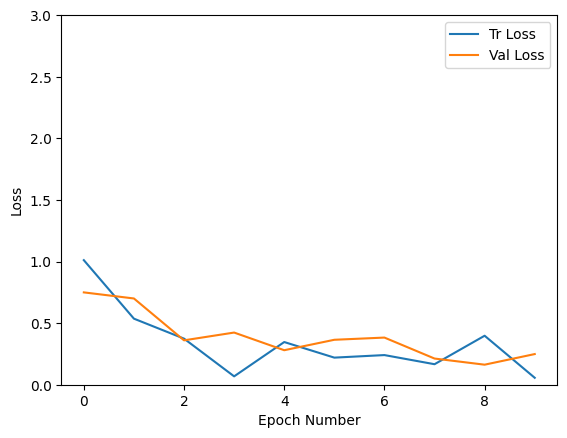

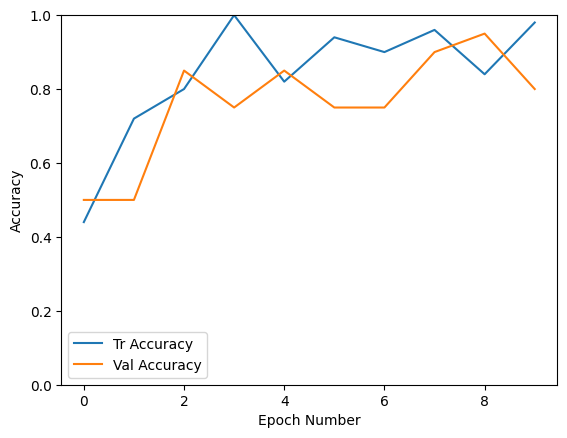

In [19]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [20]:
import cv2
import torchvision.transforms as transforms
from PIL import Image
import torch

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# Define class labels (ensure this matches training order)
idx_to_class = {0: 'glasses', 1: 'no_glasses'}

# Define image transform (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Start webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open webcam")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Draw rectangle around face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Crop face and convert to PIL Image
        face_img = frame[y:y+h, x:x+w]
        face_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))

        # Transform and predict
        input_tensor = transform(face_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            class_name = idx_to_class[pred.item()]

        # Put prediction text above the rectangle
        cv2.putText(frame, class_name, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Show frame
    cv2.imshow("Webcam - Glasses Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 